# Simple GRU Model

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
train_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_x.csv')
train_y = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_y.csv')
test_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/test_x.csv')

In [3]:
# Display the first few rows
print(train_x.head())
print(train_x.shape)

   Hour  ID    Age  Gender  Unit1  Unit2     HR   O2Sat   Temp     SBP  ...  \
0     1   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
1     2   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
2     3   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
3     4   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
4     5   2  66.67     1.0    0.0    1.0  84.42   99.58  35.61  114.60  ...   

   Phosphate  Potassium  Bilirubin_total  TroponinI    Hct   Hgb  PTT   WBC  \
0        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
1        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
2        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
3        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
4        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   

   Fibrinogen  Platelets  
0         NaN        Na

In [4]:
print(train_y.head())
print(train_y.shape)

   ID  Outcome
0   2        0
1   3        0
2   5        1
3   6        0
4  13        0
(12115, 2)


In [5]:
max_hours = train_x.groupby('ID')['Hour'].count().max()
print(f'Maximum number of hours: {max_hours}')

Maximum number of hours: 336


In [6]:
# Get unique person IDs
person_ids = train_x['ID'].unique()

# Initialize tensors for features, masks, and time intervals
num_persons = len(person_ids)
num_features = train_x.shape[1] - 2  # excluding 'ID' and 'Hour' columns

In [7]:
person_ids

array([    2,     3,     5, ..., 21630, 21632, 21633])

In [8]:
#Initialize tensors
X_tensor = np.zeros((num_persons, max_hours, num_features+1))

In [9]:
for i, person_id in enumerate(person_ids):
    person_data = train_x[train_x['ID'] == person_id].sort_values('Hour')
    hours = person_data['Hour'].values
    features = person_data.drop(columns=['ID']).values
    
    # Fill X_tensor
    X_tensor[i, :len(hours), :] = features

In [10]:
X_tensor

array([[[  1.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  2.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  3.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  2.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  3.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  2.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  3.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        ...,
        [  0

In [11]:
# Replace NaNs with zeros in X_tensor
X_tensor = np.nan_to_num(X_tensor)

print(X_tensor.shape)

(12115, 336, 39)


In [12]:
# Ensure train_y is aligned with X_tensor
labels = np.zeros(len(person_ids))

for i, person_id in enumerate(person_ids):
    if person_id in train_y['ID'].values:
        labels[i] = train_y[train_y['ID'] == person_id]['Outcome'].values[0]

print(labels.shape)

(12115,)


In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, labels, test_size=0.2, random_state=10
)

In [14]:
def create_gru_model(input_shape, learning_rate=0.001, dropout_rate=0.2, regularization_factor=0.001):
    x_input = Input(shape=input_shape)
    
    # GRU layers with dropout, batch normalization, and regularization
    gru_output = GRU(units=64, return_sequences=False, kernel_regularizer=l2(regularization_factor))(x_input)
    gru_output = BatchNormalization()(gru_output)
    gru_output = Dropout(dropout_rate)(gru_output)
    
    # Output layer
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(regularization_factor))(gru_output)
    
    # Create model
    model = Model(inputs=x_input, outputs=output)
    
    # Create an Adam optimizer with a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
    
    return model

In [15]:
input_shape = (max_hours, num_features+1)
model_gru = create_gru_model(input_shape)

history = model_gru.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 7:51 975ms/step - AUC: 0.5000 - accuracy: 0.8125 - loss: 0.7608

  3/485 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 0.5178 - accuracy: 0.8125 - loss: 0.7587  

  5/485 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - AUC: 0.5113 - accuracy: 0.8069 - loss: 0.7567

  7/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.5237 - accuracy: 0.8110 - loss: 0.7543

  9/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.5194 - accuracy: 0.8105 - loss: 0.7523

 11/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.5208 - accuracy: 0.8119 - loss: 0.7501

 13/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.5254 - accuracy: 0.8147 - loss: 0.7477

 15/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.5252 - accuracy: 0.8161 - loss: 0.7455

 17/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.5282 - accuracy: 0.8183 - loss: 0.7432

 19/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 0.5274 - accuracy: 0.8195 - loss: 0.7410

 21/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5258 - accuracy: 0.8203 - loss: 0.7388

 23/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5249 - accuracy: 0.8212 - loss: 0.7366

 25/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5262 - accuracy: 0.8226 - loss: 0.7343

 27/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5274 - accuracy: 0.8240 - loss: 0.7319

 29/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5286 - accuracy: 0.8253 - loss: 0.7296

 31/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5296 - accuracy: 0.8266 - loss: 0.7272

 33/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5291 - accuracy: 0.8274 - loss: 0.7249

 35/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5281 - accuracy: 0.8281 - loss: 0.7228

 37/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5269 - accuracy: 0.8286 - loss: 0.7206

 39/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5255 - accuracy: 0.8289 - loss: 0.7185

 41/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5237 - accuracy: 0.8290 - loss: 0.7165

 43/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5226 - accuracy: 0.8293 - loss: 0.7144

 45/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5221 - accuracy: 0.8297 - loss: 0.7122

 47/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5222 - accuracy: 0.8302 - loss: 0.7100

 49/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5227 - accuracy: 0.8309 - loss: 0.7077

 51/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5228 - accuracy: 0.8314 - loss: 0.7055

 53/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5233 - accuracy: 0.8320 - loss: 0.7032

 55/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5240 - accuracy: 0.8326 - loss: 0.7009

 57/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5251 - accuracy: 0.8333 - loss: 0.6985

 59/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5262 - accuracy: 0.8340 - loss: 0.6961

 61/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5271 - accuracy: 0.8347 - loss: 0.6938

 63/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5281 - accuracy: 0.8354 - loss: 0.6914

 65/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5293 - accuracy: 0.8361 - loss: 0.6890

 67/485 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 0.5305 - accuracy: 0.8369 - loss: 0.6866

 69/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5313 - accuracy: 0.8375 - loss: 0.6842

 71/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5322 - accuracy: 0.8382 - loss: 0.6818

 73/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5333 - accuracy: 0.8389 - loss: 0.6794

 75/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5341 - accuracy: 0.8395 - loss: 0.6771

 77/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5349 - accuracy: 0.8402 - loss: 0.6747

 79/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5355 - accuracy: 0.8407 - loss: 0.6724

 81/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5358 - accuracy: 0.8412 - loss: 0.6702

 83/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5363 - accuracy: 0.8418 - loss: 0.6680

 85/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5367 - accuracy: 0.8423 - loss: 0.6658

 87/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5370 - accuracy: 0.8428 - loss: 0.6636

 89/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5373 - accuracy: 0.8433 - loss: 0.6614

 91/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5378 - accuracy: 0.8438 - loss: 0.6592

 93/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5382 - accuracy: 0.8443 - loss: 0.6570

 95/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5382 - accuracy: 0.8447 - loss: 0.6549

 97/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5382 - accuracy: 0.8450 - loss: 0.6529

 99/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5380 - accuracy: 0.8454 - loss: 0.6510

101/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5379 - accuracy: 0.8457 - loss: 0.6490

103/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5378 - accuracy: 0.8460 - loss: 0.6471

105/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5378 - accuracy: 0.8463 - loss: 0.6452

107/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5377 - accuracy: 0.8467 - loss: 0.6433

109/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5377 - accuracy: 0.8470 - loss: 0.6414

111/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5377 - accuracy: 0.8473 - loss: 0.6395

113/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5377 - accuracy: 0.8476 - loss: 0.6376

115/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5377 - accuracy: 0.8479 - loss: 0.6358

117/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5376 - accuracy: 0.8482 - loss: 0.6340

119/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5374 - accuracy: 0.8485 - loss: 0.6323

121/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5372 - accuracy: 0.8487 - loss: 0.6306

123/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5370 - accuracy: 0.8490 - loss: 0.6289

125/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5368 - accuracy: 0.8492 - loss: 0.6272

127/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5365 - accuracy: 0.8494 - loss: 0.6256

129/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5364 - accuracy: 0.8496 - loss: 0.6240

131/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5362 - accuracy: 0.8499 - loss: 0.6224

133/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5360 - accuracy: 0.8501 - loss: 0.6208

135/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5358 - accuracy: 0.8503 - loss: 0.6192

137/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5355 - accuracy: 0.8504 - loss: 0.6178

139/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5352 - accuracy: 0.8506 - loss: 0.6163

141/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5349 - accuracy: 0.8508 - loss: 0.6148

143/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5347 - accuracy: 0.8510 - loss: 0.6133

145/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5344 - accuracy: 0.8511 - loss: 0.6119

147/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5341 - accuracy: 0.8513 - loss: 0.6105

149/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5339 - accuracy: 0.8515 - loss: 0.6092

151/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5335 - accuracy: 0.8516 - loss: 0.6078

153/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5332 - accuracy: 0.8517 - loss: 0.6065

155/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5329 - accuracy: 0.8519 - loss: 0.6052

157/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.5326 - accuracy: 0.8520 - loss: 0.6039

159/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5323 - accuracy: 0.8521 - loss: 0.6026

161/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5319 - accuracy: 0.8522 - loss: 0.6014

163/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5315 - accuracy: 0.8523 - loss: 0.6002

165/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5311 - accuracy: 0.8524 - loss: 0.5991

167/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5308 - accuracy: 0.8525 - loss: 0.5979

169/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5304 - accuracy: 0.8526 - loss: 0.5967

171/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5300 - accuracy: 0.8527 - loss: 0.5956

173/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5297 - accuracy: 0.8528 - loss: 0.5945

175/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5293 - accuracy: 0.8529 - loss: 0.5934

177/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5290 - accuracy: 0.8529 - loss: 0.5923

179/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5287 - accuracy: 0.8530 - loss: 0.5912

181/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5284 - accuracy: 0.8531 - loss: 0.5901

183/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5281 - accuracy: 0.8532 - loss: 0.5890

185/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5277 - accuracy: 0.8533 - loss: 0.5880

187/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5274 - accuracy: 0.8533 - loss: 0.5870

189/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5271 - accuracy: 0.8534 - loss: 0.5860

191/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5268 - accuracy: 0.8535 - loss: 0.5850 

193/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5265 - accuracy: 0.8535 - loss: 0.5840

195/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5262 - accuracy: 0.8536 - loss: 0.5830

197/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5259 - accuracy: 0.8537 - loss: 0.5821

199/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5256 - accuracy: 0.8537 - loss: 0.5811

201/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5253 - accuracy: 0.8538 - loss: 0.5802

203/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5249 - accuracy: 0.8538 - loss: 0.5793

205/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5246 - accuracy: 0.8539 - loss: 0.5784

207/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5243 - accuracy: 0.8539 - loss: 0.5775

209/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5240 - accuracy: 0.8540 - loss: 0.5766

211/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5237 - accuracy: 0.8540 - loss: 0.5757

213/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5234 - accuracy: 0.8541 - loss: 0.5749

215/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5231 - accuracy: 0.8542 - loss: 0.5740

217/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5229 - accuracy: 0.8542 - loss: 0.5731

219/485 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 0.5226 - accuracy: 0.8543 - loss: 0.5723

221/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5223 - accuracy: 0.8543 - loss: 0.5715

223/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5220 - accuracy: 0.8544 - loss: 0.5706

225/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5217 - accuracy: 0.8544 - loss: 0.5698

227/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5214 - accuracy: 0.8545 - loss: 0.5690

229/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5212 - accuracy: 0.8545 - loss: 0.5682

231/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5209 - accuracy: 0.8546 - loss: 0.5674

233/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5207 - accuracy: 0.8546 - loss: 0.5666

235/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5204 - accuracy: 0.8547 - loss: 0.5658

237/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5201 - accuracy: 0.8547 - loss: 0.5651

239/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5199 - accuracy: 0.8548 - loss: 0.5643

241/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5197 - accuracy: 0.8548 - loss: 0.5636

243/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5195 - accuracy: 0.8549 - loss: 0.5628

245/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5193 - accuracy: 0.8549 - loss: 0.5621

247/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5190 - accuracy: 0.8550 - loss: 0.5613

249/485 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5188 - accuracy: 0.8550 - loss: 0.5606

251/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5186 - accuracy: 0.8551 - loss: 0.5599

253/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5183 - accuracy: 0.8551 - loss: 0.5592

255/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5181 - accuracy: 0.8551 - loss: 0.5585

257/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5179 - accuracy: 0.8552 - loss: 0.5579

259/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5176 - accuracy: 0.8552 - loss: 0.5572

261/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5174 - accuracy: 0.8552 - loss: 0.5565

263/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5172 - accuracy: 0.8553 - loss: 0.5559

265/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5170 - accuracy: 0.8553 - loss: 0.5552

267/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5168 - accuracy: 0.8553 - loss: 0.5546

269/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5166 - accuracy: 0.8554 - loss: 0.5539

271/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5163 - accuracy: 0.8554 - loss: 0.5533

273/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5161 - accuracy: 0.8554 - loss: 0.5527

275/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5159 - accuracy: 0.8554 - loss: 0.5521

277/485 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5157 - accuracy: 0.8555 - loss: 0.5515

279/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5155 - accuracy: 0.8555 - loss: 0.5509

281/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5153 - accuracy: 0.8555 - loss: 0.5503

283/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5151 - accuracy: 0.8556 - loss: 0.5497

285/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5150 - accuracy: 0.8556 - loss: 0.5491

287/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5148 - accuracy: 0.8556 - loss: 0.5485

289/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5146 - accuracy: 0.8557 - loss: 0.5479

291/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5144 - accuracy: 0.8557 - loss: 0.5473

293/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5143 - accuracy: 0.8557 - loss: 0.5467

295/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5141 - accuracy: 0.8557 - loss: 0.5461

297/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5139 - accuracy: 0.8558 - loss: 0.5456

299/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5137 - accuracy: 0.8558 - loss: 0.5450

301/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5135 - accuracy: 0.8558 - loss: 0.5445

303/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5133 - accuracy: 0.8558 - loss: 0.5440

304/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5133 - accuracy: 0.8559 - loss: 0.5437

305/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5132 - accuracy: 0.8559 - loss: 0.5434

306/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5131 - accuracy: 0.8559 - loss: 0.5432

307/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5130 - accuracy: 0.8559 - loss: 0.5429

309/485 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.5128 - accuracy: 0.8559 - loss: 0.5423

311/485 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 0.5127 - accuracy: 0.8560 - loss: 0.5418

312/485 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 0.5126 - accuracy: 0.8560 - loss: 0.5415

313/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5125 - accuracy: 0.8560 - loss: 0.5413

314/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5125 - accuracy: 0.8560 - loss: 0.5410

316/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5123 - accuracy: 0.8560 - loss: 0.5405

318/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5122 - accuracy: 0.8561 - loss: 0.5399

320/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5121 - accuracy: 0.8561 - loss: 0.5394

322/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5120 - accuracy: 0.8562 - loss: 0.5389

324/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5118 - accuracy: 0.8562 - loss: 0.5383

326/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5117 - accuracy: 0.8562 - loss: 0.5378

328/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5116 - accuracy: 0.8563 - loss: 0.5373

330/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5115 - accuracy: 0.8563 - loss: 0.5368

332/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5114 - accuracy: 0.8564 - loss: 0.5363

334/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5113 - accuracy: 0.8564 - loss: 0.5358

336/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5112 - accuracy: 0.8565 - loss: 0.5352

338/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5112 - accuracy: 0.8565 - loss: 0.5347

340/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5111 - accuracy: 0.8565 - loss: 0.5342

342/485 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.5110 - accuracy: 0.8566 - loss: 0.5337

343/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5109 - accuracy: 0.8566 - loss: 0.5335

345/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5109 - accuracy: 0.8566 - loss: 0.5330

347/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5108 - accuracy: 0.8567 - loss: 0.5325

349/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5107 - accuracy: 0.8567 - loss: 0.5321

351/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5106 - accuracy: 0.8568 - loss: 0.5316

353/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5105 - accuracy: 0.8568 - loss: 0.5311

355/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5105 - accuracy: 0.8568 - loss: 0.5306

357/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5104 - accuracy: 0.8569 - loss: 0.5301

359/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5104 - accuracy: 0.8569 - loss: 0.5297

361/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5103 - accuracy: 0.8570 - loss: 0.5292

363/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5103 - accuracy: 0.8570 - loss: 0.5287

365/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5103 - accuracy: 0.8571 - loss: 0.5282

367/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5102 - accuracy: 0.8571 - loss: 0.5278

369/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5102 - accuracy: 0.8572 - loss: 0.5273

371/485 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.5102 - accuracy: 0.8572 - loss: 0.5268

373/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8573 - loss: 0.5263

375/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8573 - loss: 0.5259

377/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8574 - loss: 0.5254

379/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8574 - loss: 0.5249

381/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8575 - loss: 0.5245

383/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8575 - loss: 0.5240

385/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8576 - loss: 0.5236

387/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8576 - loss: 0.5231

389/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8577 - loss: 0.5227

391/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8578 - loss: 0.5222

393/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8578 - loss: 0.5218

395/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8578 - loss: 0.5213

397/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8579 - loss: 0.5209

399/485 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5102 - accuracy: 0.8579 - loss: 0.5205

401/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5101 - accuracy: 0.8580 - loss: 0.5201

403/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5101 - accuracy: 0.8580 - loss: 0.5197

405/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5101 - accuracy: 0.8581 - loss: 0.5193

407/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5100 - accuracy: 0.8581 - loss: 0.5189

409/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5100 - accuracy: 0.8581 - loss: 0.5185

411/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5099 - accuracy: 0.8582 - loss: 0.5181

413/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5099 - accuracy: 0.8582 - loss: 0.5177

415/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5098 - accuracy: 0.8582 - loss: 0.5174

417/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5098 - accuracy: 0.8583 - loss: 0.5170

419/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5097 - accuracy: 0.8583 - loss: 0.5166

421/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5097 - accuracy: 0.8583 - loss: 0.5162

423/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5096 - accuracy: 0.8584 - loss: 0.5159

425/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5096 - accuracy: 0.8584 - loss: 0.5155

427/485 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 0.5096 - accuracy: 0.8584 - loss: 0.5151

429/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5095 - accuracy: 0.8585 - loss: 0.5148

431/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5095 - accuracy: 0.8585 - loss: 0.5144

433/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5094 - accuracy: 0.8585 - loss: 0.5140

435/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5094 - accuracy: 0.8586 - loss: 0.5137

437/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5093 - accuracy: 0.8586 - loss: 0.5133

439/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5093 - accuracy: 0.8586 - loss: 0.5130

441/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5093 - accuracy: 0.8587 - loss: 0.5126

443/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5092 - accuracy: 0.8587 - loss: 0.5122

445/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5092 - accuracy: 0.8587 - loss: 0.5119

447/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5092 - accuracy: 0.8588 - loss: 0.5115

449/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5091 - accuracy: 0.8588 - loss: 0.5112

451/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5091 - accuracy: 0.8589 - loss: 0.5108

453/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5091 - accuracy: 0.8589 - loss: 0.5105

455/485 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 0.5091 - accuracy: 0.8589 - loss: 0.5101

457/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5090 - accuracy: 0.8590 - loss: 0.5098

459/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5090 - accuracy: 0.8590 - loss: 0.5095

461/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5090 - accuracy: 0.8590 - loss: 0.5091

463/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5089 - accuracy: 0.8591 - loss: 0.5088

465/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5089 - accuracy: 0.8591 - loss: 0.5085

467/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5089 - accuracy: 0.8591 - loss: 0.5081

469/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5088 - accuracy: 0.8592 - loss: 0.5078

471/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5088 - accuracy: 0.8592 - loss: 0.5075

473/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5088 - accuracy: 0.8592 - loss: 0.5072

475/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5087 - accuracy: 0.8593 - loss: 0.5069

477/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5087 - accuracy: 0.8593 - loss: 0.5065

479/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5087 - accuracy: 0.8593 - loss: 0.5062

481/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5086 - accuracy: 0.8593 - loss: 0.5059

483/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5086 - accuracy: 0.8594 - loss: 0.5056

485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5086 - accuracy: 0.8594 - loss: 0.5053

485/485 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - AUC: 0.5085 - accuracy: 0.8594 - loss: 0.5051 - val_AUC: 0.5015 - val_accuracy: 0.8566 - val_loss: 0.4449


Epoch 2/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - AUC: 0.3750 - accuracy: 0.7500 - loss: 0.6234

  3/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.3553 - accuracy: 0.8021 - loss: 0.5274

  5/485 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - AUC: 0.3757 - accuracy: 0.8169 - loss: 0.4987

  7/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.3935 - accuracy: 0.8267 - loss: 0.4793

  9/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.4154 - accuracy: 0.8316 - loss: 0.4688

 11/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.4280 - accuracy: 0.8363 - loss: 0.4592

 13/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 0.4372 - accuracy: 0.8407 - loss: 0.4504

 15/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 0.4463 - accuracy: 0.8438 - loss: 0.4441

 17/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.4573 - accuracy: 0.8466 - loss: 0.4383

 19/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.4650 - accuracy: 0.8487 - loss: 0.4340

 21/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.4711 - accuracy: 0.8506 - loss: 0.4301

 23/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.4751 - accuracy: 0.8521 - loss: 0.4271

 25/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.4776 - accuracy: 0.8537 - loss: 0.4241

 27/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.4794 - accuracy: 0.8550 - loss: 0.4215

 29/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.4811 - accuracy: 0.8563 - loss: 0.4190

 31/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.4837 - accuracy: 0.8576 - loss: 0.4163

 33/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.4863 - accuracy: 0.8590 - loss: 0.4137

 35/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.4886 - accuracy: 0.8601 - loss: 0.4115

 37/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4905 - accuracy: 0.8610 - loss: 0.4096

 39/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4926 - accuracy: 0.8618 - loss: 0.4080

 41/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4938 - accuracy: 0.8624 - loss: 0.4069

 43/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4946 - accuracy: 0.8629 - loss: 0.4059

 45/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4954 - accuracy: 0.8632 - loss: 0.4054

 47/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4967 - accuracy: 0.8635 - loss: 0.4047

 49/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4979 - accuracy: 0.8640 - loss: 0.4038

 51/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4988 - accuracy: 0.8645 - loss: 0.4028

 53/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4993 - accuracy: 0.8650 - loss: 0.4018

 55/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4996 - accuracy: 0.8654 - loss: 0.4010

 57/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5000 - accuracy: 0.8658 - loss: 0.4002

 59/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5003 - accuracy: 0.8662 - loss: 0.3995

 61/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5005 - accuracy: 0.8664 - loss: 0.3990

 63/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5008 - accuracy: 0.8666 - loss: 0.3986

 65/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5010 - accuracy: 0.8668 - loss: 0.3982

 67/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5012 - accuracy: 0.8671 - loss: 0.3978

 69/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5013 - accuracy: 0.8673 - loss: 0.3973

 71/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5014 - accuracy: 0.8675 - loss: 0.3969

 73/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5016 - accuracy: 0.8677 - loss: 0.3965

 75/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5019 - accuracy: 0.8679 - loss: 0.3962

 77/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5023 - accuracy: 0.8680 - loss: 0.3960

 79/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5025 - accuracy: 0.8682 - loss: 0.3957

 81/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5029 - accuracy: 0.8683 - loss: 0.3954

 83/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5033 - accuracy: 0.8685 - loss: 0.3951

 85/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5034 - accuracy: 0.8686 - loss: 0.3948

 87/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5035 - accuracy: 0.8687 - loss: 0.3946

 89/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5035 - accuracy: 0.8688 - loss: 0.3944

 91/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5034 - accuracy: 0.8690 - loss: 0.3941

 93/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5031 - accuracy: 0.8691 - loss: 0.3939

 95/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5029 - accuracy: 0.8692 - loss: 0.3938

 97/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5027 - accuracy: 0.8693 - loss: 0.3936

 99/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5024 - accuracy: 0.8694 - loss: 0.3934

101/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5023 - accuracy: 0.8695 - loss: 0.3932

103/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5020 - accuracy: 0.8696 - loss: 0.3930

105/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5018 - accuracy: 0.8696 - loss: 0.3929

107/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5016 - accuracy: 0.8697 - loss: 0.3928

109/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5014 - accuracy: 0.8698 - loss: 0.3927

111/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5012 - accuracy: 0.8698 - loss: 0.3925

113/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5010 - accuracy: 0.8699 - loss: 0.3924

115/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5009 - accuracy: 0.8700 - loss: 0.3923

117/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5007 - accuracy: 0.8700 - loss: 0.3922

119/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5005 - accuracy: 0.8701 - loss: 0.3921

121/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5003 - accuracy: 0.8701 - loss: 0.3920

123/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.5001 - accuracy: 0.8702 - loss: 0.3920

125/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.4999 - accuracy: 0.8702 - loss: 0.3919

127/485 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 0.4998 - accuracy: 0.8702 - loss: 0.3919

129/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4997 - accuracy: 0.8703 - loss: 0.3918

131/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4996 - accuracy: 0.8703 - loss: 0.3917

133/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4995 - accuracy: 0.8704 - loss: 0.3915

135/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4994 - accuracy: 0.8705 - loss: 0.3914

137/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4994 - accuracy: 0.8705 - loss: 0.3913

139/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4994 - accuracy: 0.8705 - loss: 0.3913

141/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4994 - accuracy: 0.8705 - loss: 0.3913

143/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4994 - accuracy: 0.8705 - loss: 0.3913

145/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4993 - accuracy: 0.8705 - loss: 0.3913

147/485 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 0.4993 - accuracy: 0.8705 - loss: 0.3913

149/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4993 - accuracy: 0.8706 - loss: 0.3913

151/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4993 - accuracy: 0.8706 - loss: 0.3913

153/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4993 - accuracy: 0.8705 - loss: 0.3913

155/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4993 - accuracy: 0.8705 - loss: 0.3913

157/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4993 - accuracy: 0.8705 - loss: 0.3914

159/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4994 - accuracy: 0.8704 - loss: 0.3915

161/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4995 - accuracy: 0.8704 - loss: 0.3915

163/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4996 - accuracy: 0.8704 - loss: 0.3916

165/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4998 - accuracy: 0.8703 - loss: 0.3917

167/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.4999 - accuracy: 0.8703 - loss: 0.3917

169/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5000 - accuracy: 0.8703 - loss: 0.3918

171/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5002 - accuracy: 0.8702 - loss: 0.3918

173/485 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 0.5003 - accuracy: 0.8702 - loss: 0.3919

175/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5004 - accuracy: 0.8702 - loss: 0.3919

177/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5005 - accuracy: 0.8701 - loss: 0.3920

179/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5006 - accuracy: 0.8701 - loss: 0.3920

181/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5007 - accuracy: 0.8701 - loss: 0.3921

183/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5008 - accuracy: 0.8700 - loss: 0.3921

185/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5009 - accuracy: 0.8700 - loss: 0.3921

187/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5010 - accuracy: 0.8700 - loss: 0.3922 

189/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5011 - accuracy: 0.8700 - loss: 0.3922

191/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5012 - accuracy: 0.8700 - loss: 0.3922

193/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5013 - accuracy: 0.8700 - loss: 0.3922

195/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5013 - accuracy: 0.8700 - loss: 0.3922

197/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5014 - accuracy: 0.8700 - loss: 0.3922

199/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5015 - accuracy: 0.8700 - loss: 0.3922

201/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5016 - accuracy: 0.8700 - loss: 0.3922

203/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5016 - accuracy: 0.8700 - loss: 0.3922

205/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5017 - accuracy: 0.8700 - loss: 0.3922

207/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5018 - accuracy: 0.8700 - loss: 0.3922

209/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5018 - accuracy: 0.8699 - loss: 0.3923

211/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5019 - accuracy: 0.8699 - loss: 0.3923

213/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5019 - accuracy: 0.8699 - loss: 0.3923

215/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5019 - accuracy: 0.8699 - loss: 0.3923

217/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5019 - accuracy: 0.8699 - loss: 0.3924

219/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5019 - accuracy: 0.8699 - loss: 0.3924

221/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5019 - accuracy: 0.8699 - loss: 0.3924

223/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5020 - accuracy: 0.8698 - loss: 0.3925

225/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5020 - accuracy: 0.8698 - loss: 0.3925

227/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5020 - accuracy: 0.8698 - loss: 0.3925

229/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5021 - accuracy: 0.8698 - loss: 0.3926

231/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5021 - accuracy: 0.8698 - loss: 0.3926

233/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5021 - accuracy: 0.8697 - loss: 0.3926

235/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5022 - accuracy: 0.8697 - loss: 0.3927

237/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5022 - accuracy: 0.8697 - loss: 0.3927

239/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5022 - accuracy: 0.8697 - loss: 0.3927

241/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5022 - accuracy: 0.8697 - loss: 0.3927

243/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5022 - accuracy: 0.8697 - loss: 0.3928

245/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5022 - accuracy: 0.8696 - loss: 0.3928

247/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5023 - accuracy: 0.8696 - loss: 0.3928

249/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5023 - accuracy: 0.8696 - loss: 0.3929

251/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5024 - accuracy: 0.8695 - loss: 0.3930

253/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5025 - accuracy: 0.8695 - loss: 0.3930

255/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5025 - accuracy: 0.8695 - loss: 0.3931

257/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5026 - accuracy: 0.8694 - loss: 0.3932

259/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5027 - accuracy: 0.8694 - loss: 0.3933

261/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5028 - accuracy: 0.8693 - loss: 0.3933

263/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5028 - accuracy: 0.8693 - loss: 0.3934

265/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5029 - accuracy: 0.8693 - loss: 0.3935

267/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5030 - accuracy: 0.8692 - loss: 0.3935

269/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5031 - accuracy: 0.8692 - loss: 0.3936

271/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5031 - accuracy: 0.8691 - loss: 0.3937

273/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5032 - accuracy: 0.8691 - loss: 0.3938

275/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5033 - accuracy: 0.8691 - loss: 0.3938

277/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5033 - accuracy: 0.8690 - loss: 0.3939

279/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5033 - accuracy: 0.8690 - loss: 0.3939

281/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5034 - accuracy: 0.8690 - loss: 0.3940

283/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5034 - accuracy: 0.8690 - loss: 0.3940

285/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5035 - accuracy: 0.8689 - loss: 0.3941

287/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5035 - accuracy: 0.8689 - loss: 0.3941

289/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5035 - accuracy: 0.8689 - loss: 0.3942

291/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5036 - accuracy: 0.8689 - loss: 0.3942

293/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5036 - accuracy: 0.8688 - loss: 0.3942

295/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5037 - accuracy: 0.8688 - loss: 0.3943

297/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5037 - accuracy: 0.8688 - loss: 0.3943

299/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5037 - accuracy: 0.8688 - loss: 0.3943

301/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5038 - accuracy: 0.8688 - loss: 0.3944

303/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5038 - accuracy: 0.8687 - loss: 0.3945

305/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5038 - accuracy: 0.8687 - loss: 0.3945

307/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5039 - accuracy: 0.8687 - loss: 0.3946

309/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5039 - accuracy: 0.8687 - loss: 0.3947

311/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5039 - accuracy: 0.8687 - loss: 0.3947

313/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5040 - accuracy: 0.8687 - loss: 0.3948

KeyboardInterrupt: 

In [16]:
# Evaluate the model on the test set
test_loss, test_auc, test_accuracy = model_gru.evaluate(X_test, y_test)
print(f'Test AUC: {test_auc}')
print(f'Test Accuracy: {test_accuracy:.4f}')

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8339 - accuracy: 0.9142 - loss: 0.3098
Test AUC: 0.8473536968231201
Test Accuracy: 0.9199


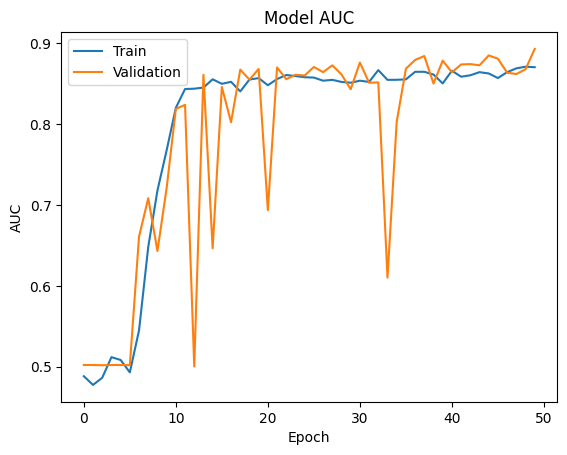

In [17]:
# Plot training & validation AUC values
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()